# Modeling for Goodreads Dataset

This notebook consists of the modeling section for my goodreads project. The model will classify a book on whether it's good or bad.

The initial dataset was sorted by its books' ratings and the top half received the label of 'good' while the bottom half was 'bad.' The ratings were then removed and randomized, and the models were trained on this dataset.

The following algorithms were tried:
* [1. Dummy Classification as a Baseline](#baseline)
* [2. Logistic Classification](#clf)
* [3. Random Forest](#rf)
* [4. AdaBoost](#ada)
* [5. KNN](#knn)

But first, since KNN is faster done when the data is normalized, the dataset will be normalized prior to any modeling. Most of the above algorithms are scale-invariant; in order to easily compare the model performances, I will be using the normalized data for all models.

* [Preprocessing](#preproc)
* [Model Performance Summary](#summary)

In [1]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Preprocessing <a name='preproc'></a>

In [3]:
#Load dataset
dataset = pd.read_csv('./data/final.csv', index_col=0)

In [4]:
dataset

,edition,pages,rating,rating_count,review_count,missing_ed,missing_desc,length,quality,Fiction,Fantasy,Romance,Young Adult,Nonfiction,Historical,Historical Fiction,Contemporary,Classics,Mystery,Cultural,Paranormal,Science Fiction,Childrens,Literature,Other,fauthor_rating,fauthor_nbooks,authors_rating,authors_nbooks,nauthors,a1plus,a3plus,a5plus,a10plus,fmt_Audio,fmt_Digital,fmt_Hardcover,fmt_Missing,fmt_Other,fmt_Paperback
0,0,870.0,4.48,2041594,33264,0.0,1.0,3.0,1.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.244412,34,4.388873,20.000000,2,1,0,0,0,0,0,0,0,0,1
1,0,193.0,4.21,1155911,23919,1.0,1.0,1.0,1.0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,4.156957,23,4.156957,23.000000,1,0,0,0,0,0,0,0,0,0,1
2,0,64.0,4.37,789681,15694,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,4.241818,11,4.241818,11.000000,1,0,0,0,0,0,0,1,0,0,0
3,0,481.0,3.81,1668594,43699,1.0,1.0,3.0,1.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.818571,14,3.818571,14.000000,1,0,0,0,0,0,0,0,0,0,1
4,0,239.0,4.07,411153,9166,1.0,1.0,2.0,1.0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4.085000,18,4.077143,9.666667,3,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38411,0,106.0,3.92,387,39,1.0,1.0,1.0,0.0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,3.920000,1,3.920000,1.000000,2,1,0,0,0,0,0,0,0,0,1
38412,0,336.0,3.60,3529,531,1.0,1.0,2.0,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,3.600000,1,3.600000,1.000000,1,0,0,0,0,0,0,0,0,0,1
38413,1,368.0,3.67,5827,816,0.0,1.0,2.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3.767500,4,3.767500,4.000000,1,0,0,0,0,0,0,1,0,0,0
38414,0,399.0,3.51,3717,661,1.0,1.0,2.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3.510000,1,3.510000,1.000000,1,0,0,0,0,0,0,1,0,0,0


In [5]:
#define independent variables and dependent variable (quality)
X = dataset.drop(columns=['quality'])
y = dataset[['quality']]

#Create test and train test while shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Save unscaled train and test data
X_train.join(y_train).to_csv('./data/train_data.csv')
X_test.join(y_test).to_csv('./data/test_data.csv')

To standardize, I will be using a `MinMaxScaler` in order to maintain the original distribution of the features.

In [6]:
#Create standardscaler
scaler = MinMaxScaler()

#Fit abd transform scaler on training data
training = scaler.fit_transform(X_train)

#Transform test data based on fitted scaler
testing = scaler.transform(X_test)

In [7]:
#Save scaled training and test data along with the depedent variables
pd.DataFrame(training, columns=X_train.columns, index=X_train.index).join(y_train).to_csv('./data/scaled_train.csv')
pd.DataFrame(testing, columns=X_test.columns, index=X_test.index).join(y_test).to_csv('./data/scaled_test.csv')

# Modeling <a name='model'></a>

In [8]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import RandomizedSearchCV

import time

import warnings
warnings.filterwarnings("ignore")

In [9]:
#Load relevant datasets
train = pd.read_csv('./data/scaled_train.csv', index_col=0).reset_index(drop=True)
test = pd.read_csv('./data/scaled_test.csv', index_col=0).reset_index(drop=True)

In [10]:
#Split the scaled dataset into independent and dependent variables
X_train = train.drop(columns=['quality'])
X_test = test.drop(columns=['quality'])
y_train = train['quality']
y_test = test['quality']

In [11]:
X_train.shape, y_train.shape

((26891, 39), (26891,))

## Setting up Evaluations for Comparison 

Helper functions will be created to evaluate my models for easier comparisons. They will plot the ROC curve as well as print out the model performances.

In [12]:
def plot_roc(fpr1, tpr1, fpr0, tpr0):
    """Plot the ROC curve."""
    
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve for 1')
    plt.plot(fpr0, tpr0, color='navy', lw=2, label='ROC curve for 0')
    plt.plot([0,1], [0,1], lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.legend()
    plt.show()

In [13]:
def evaluate(model, X_train, X_test, y_train, y_test):
    """Obtain the metrics for evaluation of the model."""
    
    #Print model name
    print(model)
    
    #Fit and predict the model
    fit_start = time.time()
    model.fit(X_train, y_train)
    fit_end = time.time()
    
    train_pred = model.predict(X_train)
    
    pred_start = time.time()
    y_pred = model.predict(X_test)
    pred_end = time.time()
    
    #Print execution time
    print('Model Fit Time: ', fit_end - fit_start, 's')
    print('Model Prediction Time: ', pred_end - pred_start, 's\n')
    
    #Print reports
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    #Get probability estimates for roc curve
    probs = model.predict_proba(X_test)
    y_score1 = probs[:,1]
    y_score0 = probs[:,0]
    
    #Calculate ROC metrics
    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_score1)
    fpr0, tpr0, thresholds0 = roc_curve(y_test, y_score0)
    
    #Print AUC
    print("AUC for classifying as good (1): {}\nAUC for classifying as bad (0): {}.".format(
        auc(fpr1, tpr1), auc(fpr0, tpr0)))
    
    plot_roc(fpr1, tpr1, fpr0, tpr0)

## Baseline <a name='baseline'></a>

To compare the efficacy my models, I will create a baseline with a uniform dummy classifier. This way, I'm not only comparing the models' performances against each other, but also seeing if they're better than random guessing.

In [14]:
#Create dummy model with uniform strategy
dummy = DummyClassifier(strategy='uniform', random_state=42)

#Fit and predict model on scaled data
dummy.fit(X_train, y_train)
dummy.predict(X_test)

#Obtain dummy score
dummy.score(X_test, y_test)

0.5048156182212581

DummyClassifier(random_state=42, strategy='uniform')
Model Fit Time:  0.0019948482513427734 s
Model Prediction Time:  0.0009963512420654297 s

              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51      5766
         1.0       0.50      0.50      0.50      5759

    accuracy                           0.50     11525
   macro avg       0.50      0.50      0.50     11525
weighted avg       0.50      0.50      0.50     11525

[[2914 2852]
 [2855 2904]]
AUC for classifying as good (1): 0.5
AUC for classifying as bad (0): 0.5.


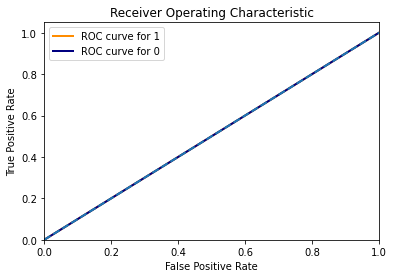

In [15]:
evaluate(dummy, X_train, X_test, y_train, y_test)

## Logistic Regression <a name='clf'></a>

To start off, a logistic regression will be created as it is one of more simpler but still efficient classification models. For tuning, as with all the rest of the models, I will be using a randomized search cv pipeline to find the best parameters.

It should be noted that logistric regression does not need any scaling, but for an even comparison with the same dataset, I will be using the scaled dataset.

In [16]:
#Create logisticregession
clf = LogisticRegression()

#Create model parameters to iterate over
params = {'solver':['newton-cg', 'lbfgs', 'liblinear'],
          'penalty': ['l1', 'l2', 'none', 'elasticnet'],
          'C': np.power(10.0, np.arange(-10,10)),
         'multi_class': ['ovr']}

#Create randomized search cv pipeline
clf_cv = RandomizedSearchCV(clf, param_distributions=params, cv=5, scoring='roc_auc')

#Fit model on training set
clf_cv.fit(X_train, y_train)

#Print the best parameters and score
print(clf_cv.best_params_, clf_cv.best_score_)

{'C': 100.0, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'} 0.5987467264780117


LogisticRegression(C=100.0, multi_class='ovr')
Model Fit Time:  0.3331129550933838 s
Model Prediction Time:  0.002985715866088867 s

              precision    recall  f1-score   support

         0.0       0.56      0.57      0.57      5766
         1.0       0.56      0.56      0.56      5759

    accuracy                           0.56     11525
   macro avg       0.56      0.56      0.56     11525
weighted avg       0.56      0.56      0.56     11525

[[3276 2490]
 [2525 3234]]
AUC for classifying as good (1): 0.5905990274041801
AUC for classifying as bad (0): 0.40940097259582.


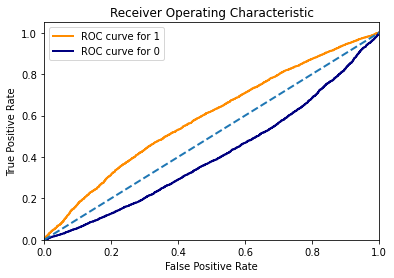

In [17]:
#Predict based on the best logistric regression hyperparameters
clf = LogisticRegression(C=100.0, multi_class='ovr', penalty='l2', solver='lbfgs')

#Evaluate the model
evaluate(clf, X_train, X_test, y_train, y_test)

## Random Forests <a name='rf'></a>

In [18]:
#Create random forest
rf = RandomForestClassifier()

#Create model parameters to iterate over
params = {'criterion': ['gini', 'entropy'], 
          'random_state':[42],
         'max_depth': [1, 3, 5, 10, 25, 50, 100],
         'n_estimators':[10, 100, 300, 500]}

#Create gridsearchcvpipeline
rf_cv = RandomizedSearchCV(rf, param_distributions=params, cv=5, scoring='roc_auc')

#Fit model on training set
rf_cv.fit(X_train, y_train)

#Print the best parameters and score
print(rf_cv.best_params_, rf_cv.best_score_)

{'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 500, 'random_state': 42} 0.7071365526402085


RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=500,
                       random_state=42)
Model Fit Time:  56.12944531440735 s
Model Prediction Time:  3.57208514213562 s

              precision    recall  f1-score   support

         0.0       0.64      0.68      0.66      5766
         1.0       0.66      0.62      0.64      5759

    accuracy                           0.65     11525
   macro avg       0.65      0.65      0.65     11525
weighted avg       0.65      0.65      0.65     11525

[[3940 1826]
 [2200 3559]]
AUC for classifying as good (1): 0.7077095905083823
AUC for classifying as bad (0): 0.2922904094916178.


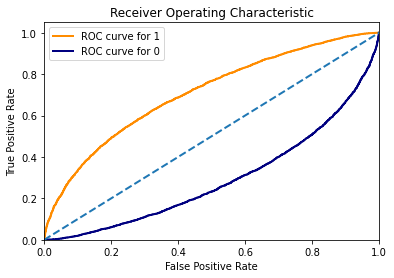

In [19]:
#Predict the model based on the best hyperparameters
rf_best = RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=500, random_state=42)

#Evaluate the model
evaluate(rf_best, X_train, X_test, y_train, y_test)

## ADA Boost

In [20]:
#Create ada boost classifier
ada = AdaBoostClassifier()

#Hyperparameters to tune
params = {'n_estimators':[10, 25, 50, 75, 100, 200, 300, 500],
          'learning_rate': [0.001, 0.001, 0.1, 0.3, 0.5, 0.7, 1, 3, 5],
          'random_state':[42]
}

#Create gridsearhcv
ada_cv = RandomizedSearchCV(ada, param_distributions=params, cv=5, scoring='roc_auc')

#Fit the model
ada_cv.fit(X_train, y_train)

#Print the best hyperparameters and score
print(ada_cv.best_params_, ada_cv.best_score_)

{'random_state': 42, 'n_estimators': 200, 'learning_rate': 0.3} 0.6814060981555177


AdaBoostClassifier(learning_rate=0.3, n_estimators=200, random_state=42)
Model Fit Time:  8.274667739868164 s
Model Prediction Time:  0.6522541046142578 s

              precision    recall  f1-score   support

         0.0       0.63      0.66      0.64      5766
         1.0       0.64      0.60      0.62      5759

    accuracy                           0.63     11525
   macro avg       0.63      0.63      0.63     11525
weighted avg       0.63      0.63      0.63     11525

[[3813 1953]
 [2276 3483]]
AUC for classifying as good (1): 0.6829056777438707
AUC for classifying as bad (0): 0.3170943222561293.


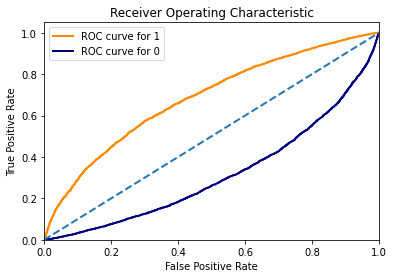

In [21]:
#Run model on best hyperparameters
ada_best = AdaBoostClassifier(random_state=42, learning_rate=0.3, n_estimators=200)

#Evaluate model
evaluate(ada_best, X_train, X_test, y_train, y_test)

## KNN <a name='knn'></a>

Because KNN is an algorithm based on distance and is scale-variant, it was important to use the normalized data. Like the other models, a RandomizedSearchCV was used to tune the model for the best parameters.

In [22]:
#Create KNN classifier
knn = KNeighborsClassifier()

#Hyperparameters to tune
params = {'n_neighbors':[3, 5, 10, 15, 20, 30, 50, 100], 
          'weights': ['uniform', 'distance'],
          'algorithm': ['auto'],
          'leaf_size':[10, 20, 30, 50, 75, 100],
          'p': [1, 2]
}

#Create gridsearchcv
knn_cv = RandomizedSearchCV(knn, param_distributions=params, cv=5, scoring='roc_auc')

#Fit model
knn_cv.fit(X_train, y_train)

#Print best hyperparameters and score
print(knn_cv.best_params_, knn_cv.best_score_)

{'weights': 'distance', 'p': 2, 'n_neighbors': 50, 'leaf_size': 50, 'algorithm': 'auto'} 0.6066274439109958


KNeighborsClassifier(leaf_size=50, n_neighbors=50, weights='distance')
Model Fit Time:  1.7871971130371094 s
Model Prediction Time:  23.68520498275757 s

              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57      5766
         1.0       0.57      0.57      0.57      5759

    accuracy                           0.57     11525
   macro avg       0.57      0.57      0.57     11525
weighted avg       0.57      0.57      0.57     11525

[[3262 2504]
 [2476 3283]]
AUC for classifying as good (1): 0.5982563779734711
AUC for classifying as bad (0): 0.401743622026529.


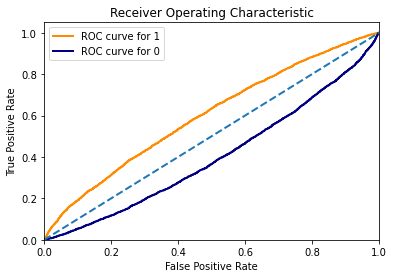

In [23]:
#Run model on best hyperparameters
knn_rbest = KNeighborsClassifier(weights='distance', p=2, n_neighbors=50, leaf_size=50)

#Evaluate model
evaluate(knn_rbest, X_train, X_test, y_train, y_test)

## Model Performance Summary <a name='summary'></a>

None of the models performed outstandingly well, and some barely did better than the baseline dummy classifier.